# Embedding Model & Cross-Encoder A/B Test

Compare embedding models and cross-encoders for WSJ news pipeline relevance filtering.

**Goals:**
1. **Post-crawl verification** — WSJ title+desc vs crawled content (800 chars)
2. **Pre-crawl ranking** — WSJ title+desc vs Google News RSS title

**Ground truth:** `wsj_llm_analysis.is_same_event` + `relevance_score >= 6` (Gemini labels, ~2,300 pairs)

### Data Limitations
1. This dataset contains only candidates already selected by the current pre-crawl ranker (top_k). Results may not generalize to the full candidate distribution.
2. Therefore, we do not claim Recall@K/MRR improvements; we only compare score separation and gate savings on the observed candidate set.
3. To validate pre-crawl improvements, we need to log/store the full candidate list per WSJ item (N=20–50) for a future evaluation run.

In [14]:
# Cell 2: Imports + Supabase connection
import gc
import os
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from dotenv import load_dotenv
from scipy.special import expit
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve
from supabase import create_client

load_dotenv(Path('..') / '.env.local')

url = os.getenv('NEXT_PUBLIC_SUPABASE_URL') or os.getenv('SUPABASE_URL')
key = os.getenv('SUPABASE_SERVICE_ROLE_KEY')
assert url and key, 'Missing Supabase credentials'
supabase = create_client(url, key)

# Device selection: MPS (Apple Silicon) > CUDA > CPU
if torch.backends.mps.is_available():
    DEVICE = 'mps'
elif torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
print(f'Connected to Supabase | Device: {DEVICE}')

Connected to Supabase | Device: mps


In [2]:
# Cell 3: Load data + merge DataFrame

def paginate_table(table, select_cols, filters=None, page_size=1000):
    """Paginate a Supabase table query."""
    all_rows = []
    offset = 0
    while True:
        q = supabase.table(table).select(select_cols)
        if filters:
            for col, op, val in filters:
                q = q.filter(col, op, val)
        batch = q.range(offset, offset + page_size - 1).execute().data or []
        all_rows.extend(batch)
        if len(batch) < page_size:
            break
        offset += page_size
    return all_rows

# Load 3 tables
crawl_rows = paginate_table(
    'wsj_crawl_results',
    'id, wsj_item_id, title, content, embedding_score',
    filters=[('crawl_status', 'eq', 'success')]
)
print(f'crawl_results: {len(crawl_rows)}')

item_rows = paginate_table('wsj_items', 'id, title, description')
print(f'wsj_items: {len(item_rows)}')

llm_rows = paginate_table('wsj_llm_analysis', 'crawl_result_id, is_same_event, relevance_score')
print(f'llm_analysis: {len(llm_rows)}')

# Build DataFrames
df_crawl = pd.DataFrame(crawl_rows)
df_items = pd.DataFrame(item_rows).rename(columns={'id': 'wsj_item_id', 'title': 'wsj_title', 'description': 'wsj_description'})
df_llm = pd.DataFrame(llm_rows).rename(columns={'crawl_result_id': 'id'})

# Merge
df = df_crawl.merge(df_items, on='wsj_item_id', how='inner')
df = df.merge(df_llm, on='id', how='inner')

# Derive columns
df['wsj_text'] = df['wsj_title'] + ' ' + df['wsj_description'].fillna('')
df['crawled_text_800'] = df['content'].fillna('').str[:800]
df['google_title'] = df['title']  # crawl_results.title = Google News RSS title
df['label'] = (df['is_same_event'] == True) | (df['relevance_score'] >= 6)

# Drop rows with missing text
df = df.dropna(subset=['wsj_text', 'crawled_text_800']).reset_index(drop=True)
df = df[df['crawled_text_800'].str.len() > 0].reset_index(drop=True)

print(f'\nMerged rows: {len(df)}')
print(f'Label distribution:\n{df["label"].value_counts()}')
print(f'\nNull check:\n{df[["wsj_text", "crawled_text_800", "google_title", "label"]].isnull().sum()}')

crawl_results: 2326
wsj_items: 1634
llm_analysis: 1967

Merged rows: 1951
Label distribution:
label
True     1068
False     883
Name: count, dtype: int64

Null check:
wsj_text            0
crawled_text_800    0
google_title        0
label               0
dtype: int64


=== DB embedding_score by label ===
        count    mean     std     min     25%     50%     75%     max
label                                                                
False   883.0  0.4359  0.1327 -0.0173  0.3496  0.4193  0.5074  0.9330
True   1068.0  0.6808  0.1381 -0.0396  0.5965  0.6956  0.7811  0.9493


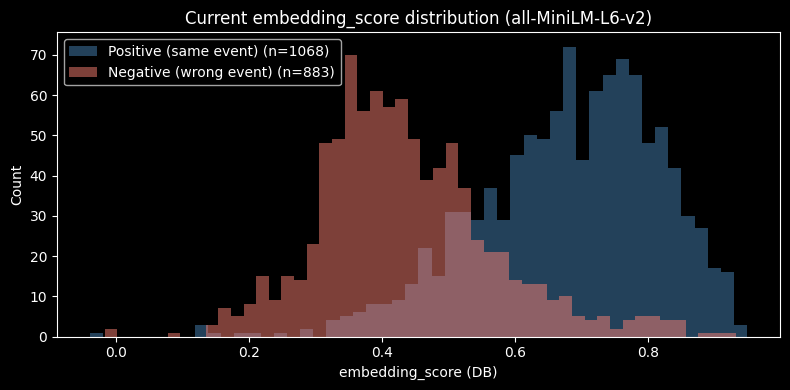

In [3]:
# Cell 4: Baseline — existing embedding_score distribution

print('=== DB embedding_score by label ===')
print(df.groupby('label')['embedding_score'].describe().round(4))

fig, ax = plt.subplots(figsize=(8, 4))
for lbl, color, name in [(True, 'steelblue', 'Positive (same event)'), (False, 'salmon', 'Negative (wrong event)')]:
    subset = df[df['label'] == lbl]['embedding_score'].dropna()
    ax.hist(subset, bins=50, alpha=0.5, color=color, label=f'{name} (n={len(subset)})')
ax.set_xlabel('embedding_score (DB)')
ax.set_ylabel('Count')
ax.set_title('Current embedding_score distribution (all-MiniLM-L6-v2)')
ax.legend()
plt.tight_layout()
plt.show()

In [4]:
# Cell 5: Helper functions

def encode_with_timing(model, texts, **kwargs):
    """Encode texts and return (embeddings, elapsed_seconds)."""
    start = time.time()
    embs = model.encode(texts, normalize_embeddings=True, show_progress_bar=True, **kwargs)
    elapsed = time.time() - start
    return embs, elapsed


def cosine_scores(embs_a, embs_b):
    """Row-wise cosine similarity (assumes normalized embeddings)."""
    return np.sum(embs_a * embs_b, axis=1)


def evaluate_model_scores(scores, labels, model_name):
    """Sweep thresholds, return dict with optimal threshold, F1, AUC, P, R."""
    labels_int = labels.astype(int).values
    auc = roc_auc_score(labels_int, scores)
    precision, recall, thresholds = precision_recall_curve(labels_int, scores)
    f1 = np.where((precision + recall) > 0, 2 * precision * recall / (precision + recall), 0)
    best_idx = np.argmax(f1)
    return {
        'model': model_name,
        'threshold': thresholds[best_idx] if best_idx < len(thresholds) else 0.5,
        'f1': f1[best_idx],
        'auc': auc,
        'precision': precision[best_idx],
        'recall': recall[best_idx],
    }


def three_zone_analysis(scores, labels, model_name, precision_target=0.95):
    """Find accept/reject/uncertain zones at target precision."""
    labels_int = labels.astype(int).values
    n = len(labels_int)

    # Sort by score descending for accept zone
    sorted_idx = np.argsort(-scores)
    sorted_labels = labels_int[sorted_idx]
    sorted_scores = scores[sorted_idx]

    # Accept zone: find threshold where precision >= target
    accept_thresh = None
    cum_tp = np.cumsum(sorted_labels)
    cum_total = np.arange(1, n + 1)
    cum_precision = cum_tp / cum_total
    # Find the largest k where precision >= target
    valid = np.where(cum_precision >= precision_target)[0]
    if len(valid) > 0:
        best_k = valid[-1]
        accept_thresh = sorted_scores[best_k]

    # Reject zone: sort ascending, find threshold where reject accuracy >= target
    sorted_idx_asc = np.argsort(scores)
    sorted_labels_asc = labels_int[sorted_idx_asc]
    sorted_scores_asc = scores[sorted_idx_asc]

    reject_thresh = None
    cum_tn = np.cumsum(1 - sorted_labels_asc)
    cum_total_asc = np.arange(1, n + 1)
    reject_acc = cum_tn / cum_total_asc
    valid_rej = np.where(reject_acc >= precision_target)[0]
    if len(valid_rej) > 0:
        best_k_rej = valid_rej[-1]
        reject_thresh = sorted_scores_asc[best_k_rej]

    # Calculate zone percentages
    if accept_thresh is not None and reject_thresh is not None and reject_thresh < accept_thresh:
        accept_pct = np.mean(scores >= accept_thresh)
        reject_pct = np.mean(scores <= reject_thresh)
        uncertain_pct = 1 - accept_pct - reject_pct
    else:
        accept_pct = 0
        reject_pct = 0
        uncertain_pct = 1.0

    return {
        'model': model_name,
        'accept_thresh': accept_thresh,
        'reject_thresh': reject_thresh,
        'accept_pct': accept_pct,
        'reject_pct': reject_pct,
        'uncertain_pct': uncertain_pct,
        'gemini_savings': 1 - uncertain_pct,
    }


# Results collector
all_results = {}  # model_name -> {scores_post, scores_pre, metrics_post, metrics_pre, timing}
print('Helper functions defined.')

Helper functions defined.


In [5]:
# Cell 6: all-MiniLM-L6-v2 (baseline)
from sentence_transformers import SentenceTransformer

model_name = 'all-MiniLM-L6-v2'
print(f'Loading {model_name} on {DEVICE}...')
model = SentenceTransformer(model_name, device=DEVICE)

# Encode query side
emb_wsj, t_wsj = encode_with_timing(model, df['wsj_text'].tolist())

# Post-crawl: wsj_text vs crawled_text_800
emb_post, t_post = encode_with_timing(model, df['crawled_text_800'].tolist())
scores_post = cosine_scores(emb_wsj, emb_post)

# Pre-crawl: wsj_text vs google_title
emb_pre, t_pre = encode_with_timing(model, df['google_title'].tolist())
scores_pre = cosine_scores(emb_wsj, emb_pre)

all_results[model_name] = {
    'scores_post': scores_post,
    'scores_pre': scores_pre,
    'timing': {'wsj': t_wsj, 'post': t_post, 'pre': t_pre},
}

del model, emb_wsj, emb_post, emb_pre
gc.collect()
print(f'Done. Timing: wsj={t_wsj:.1f}s, post={t_post:.1f}s, pre={t_pre:.1f}s')

/Users/youngmincho/Project/araverus/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading all-MiniLM-L6-v2 on mps...


Batches: 100%|██████████| 61/61 [00:01<00:00, 59.63it/s]


Done. Timing: wsj=2.1s, post=5.6s, pre=1.0s


In [6]:
# Cell 7: bge-base-en-v1.5 (current thread model)
from sentence_transformers import SentenceTransformer

BGE_PREFIX = 'Represent this sentence for searching relevant passages: '
model_name_base = 'BAAI/bge-base-en-v1.5'
print(f'Loading {model_name_base} on {DEVICE}...')
model = SentenceTransformer(model_name_base, device=DEVICE)

# --- Without prefix (current embed_and_thread.py behavior) ---
emb_wsj_noprefix, _ = encode_with_timing(model, df['wsj_text'].tolist())
emb_post_noprefix, _ = encode_with_timing(model, df['crawled_text_800'].tolist())
scores_post_noprefix = cosine_scores(emb_wsj_noprefix, emb_post_noprefix)

# --- With prefix (bge recommended for retrieval) ---
wsj_texts_prefixed = [BGE_PREFIX + t for t in df['wsj_text'].tolist()]
emb_wsj_prefix, _ = encode_with_timing(model, wsj_texts_prefixed)
# Doc side: no prefix per bge docs
scores_post_prefix = cosine_scores(emb_wsj_prefix, emb_post_noprefix)

# Compare which is better
m_noprefix = evaluate_model_scores(scores_post_noprefix, df['label'], 'bge-base (no prefix)')
m_prefix = evaluate_model_scores(scores_post_prefix, df['label'], 'bge-base (prefix)')
print(f'No prefix: F1={m_noprefix["f1"]:.4f}, AUC={m_noprefix["auc"]:.4f}')
print(f'With prefix: F1={m_prefix["f1"]:.4f}, AUC={m_prefix["auc"]:.4f}')

use_prefix = m_prefix['f1'] > m_noprefix['f1']
print(f'\n=> Using {"prefix" if use_prefix else "no prefix"} for bge models')

# Encode pre-crawl with winner config
emb_wsj_best = emb_wsj_prefix if use_prefix else emb_wsj_noprefix
emb_pre, t_pre = encode_with_timing(model, df['google_title'].tolist())
scores_pre = cosine_scores(emb_wsj_best, emb_pre)

# Store timing for full encode (query + doc)
_, t_wsj = encode_with_timing(model, wsj_texts_prefixed if use_prefix else df['wsj_text'].tolist())
_, t_post = encode_with_timing(model, df['crawled_text_800'].tolist())

all_results['bge-base-en-v1.5'] = {
    'scores_post': scores_post_prefix if use_prefix else scores_post_noprefix,
    'scores_pre': scores_pre,
    'timing': {'wsj': t_wsj, 'post': t_post, 'pre': t_pre},
    'use_prefix': use_prefix,
}

del model, emb_wsj_noprefix, emb_post_noprefix, emb_wsj_prefix, emb_wsj_best, emb_pre
gc.collect()
print(f'Done. Timing: wsj={t_wsj:.1f}s, post={t_post:.1f}s, pre={t_pre:.1f}s')

Loading BAAI/bge-base-en-v1.5 on mps...


Batches: 100%|██████████| 61/61 [00:05<00:00, 10.80it/s]


No prefix: F1=0.8783, AUC=0.9375
With prefix: F1=0.8774, AUC=0.9371

=> Using no prefix for bge models


Batches: 100%|██████████| 61/61 [00:25<00:00,  2.44it/s]

Done. Timing: wsj=4.6s, post=25.1s, pre=3.0s


In [7]:
# Cell 8: bge-large-en-v1.5
from sentence_transformers import SentenceTransformer

model_name = 'BAAI/bge-large-en-v1.5'
print(f'Loading {model_name} on {DEVICE}...')
model = SentenceTransformer(model_name, device=DEVICE)

# Use prefix setting from bge-base test
bge_use_prefix = all_results.get('bge-base-en-v1.5', {}).get('use_prefix', True)
print(f'Using prefix: {bge_use_prefix}')

wsj_texts = [BGE_PREFIX + t for t in df['wsj_text'].tolist()] if bge_use_prefix else df['wsj_text'].tolist()
emb_wsj, t_wsj = encode_with_timing(model, wsj_texts)

# Post-crawl
emb_post, t_post = encode_with_timing(model, df['crawled_text_800'].tolist())
scores_post = cosine_scores(emb_wsj, emb_post)

# Pre-crawl
emb_pre, t_pre = encode_with_timing(model, df['google_title'].tolist())
scores_pre = cosine_scores(emb_wsj, emb_pre)

all_results['bge-large-en-v1.5'] = {
    'scores_post': scores_post,
    'scores_pre': scores_pre,
    'timing': {'wsj': t_wsj, 'post': t_post, 'pre': t_pre},
}

del model, emb_wsj, emb_post, emb_pre
gc.collect()
print(f'Done. Timing: wsj={t_wsj:.1f}s, post={t_post:.1f}s, pre={t_pre:.1f}s')

Loading BAAI/bge-large-en-v1.5 on mps...
Using prefix: False


Batches: 100%|██████████| 61/61 [00:08<00:00,  6.97it/s]


Done. Timing: wsj=15.0s, post=84.3s, pre=8.8s


In [8]:
# Cell 9: Qwen3-Embedding-0.6B
from sentence_transformers import SentenceTransformer

model_name = 'Qwen/Qwen3-Embedding-0.6B'
try:
    print(f'Loading {model_name} on {DEVICE}...')
    model = SentenceTransformer(model_name, trust_remote_code=True, device=DEVICE)

    # Try prompt_name="query" first
    try:
        emb_wsj, t_wsj = encode_with_timing(model, df['wsj_text'].tolist(), prompt_name='query')
        print('Using prompt_name="query"')
    except Exception:
        print('prompt_name="query" failed, using no prompt')
        emb_wsj, t_wsj = encode_with_timing(model, df['wsj_text'].tolist())

    # Post-crawl
    emb_post, t_post = encode_with_timing(model, df['crawled_text_800'].tolist())
    scores_post = cosine_scores(emb_wsj, emb_post)

    # Pre-crawl
    emb_pre, t_pre = encode_with_timing(model, df['google_title'].tolist())
    scores_pre = cosine_scores(emb_wsj, emb_pre)

    all_results['Qwen3-Embedding-0.6B'] = {
        'scores_post': scores_post,
        'scores_pre': scores_pre,
        'timing': {'wsj': t_wsj, 'post': t_post, 'pre': t_pre},
    }

    del model, emb_wsj, emb_post, emb_pre
    gc.collect()
    print(f'Done. Timing: wsj={t_wsj:.1f}s, post={t_post:.1f}s, pre={t_pre:.1f}s')

except Exception as e:
    print(f'SKIPPED {model_name}: {e}')

Loading Qwen/Qwen3-Embedding-0.6B on mps...


Batches: 100%|██████████| 61/61 [00:57<00:00,  1.06it/s]


Using prompt_name="query"


Batches:  38%|███▊      | 23/61 [08:22<13:50, 21.85s/it]

SKIPPED Qwen/Qwen3-Embedding-0.6B: MPS backend out of memory (MPS allocated: 10.62 GiB, other allocations: 7.38 GiB, max allowed: 18.13 GiB). Tried to allocate 196.27 MiB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).


In [9]:
# Cell 10: Cross-encoder — ms-marco-MiniLM-L-12-v2
from sentence_transformers import CrossEncoder

model_name = 'cross-encoder/ms-marco-MiniLM-L-12-v2'
print(f'Loading {model_name} on {DEVICE}...')
model = CrossEncoder(model_name, device=DEVICE)

# Post-crawl pairs
pairs_post = list(zip(df['wsj_text'].tolist(), df['crawled_text_800'].tolist()))
start = time.time()
raw_post = model.predict(pairs_post, show_progress_bar=True)
t_post = time.time() - start
scores_post = expit(raw_post)  # sigmoid normalize

# Pre-crawl pairs
pairs_pre = list(zip(df['wsj_text'].tolist(), df['google_title'].tolist()))
start = time.time()
raw_pre = model.predict(pairs_pre, show_progress_bar=True)
t_pre = time.time() - start
scores_pre = expit(raw_pre)

all_results['CE: ms-marco-MiniLM'] = {
    'scores_post': scores_post,
    'scores_pre': scores_pre,
    'timing': {'post': t_post, 'pre': t_pre},
}

del model
gc.collect()
print(f'Done. Timing: post={t_post:.1f}s, pre={t_pre:.1f}s')

Loading cross-encoder/ms-marco-MiniLM-L-12-v2 on mps...


Batches: 100%|██████████| 61/61 [00:04<00:00, 12.39it/s]


Done. Timing: post=31.6s, pre=5.2s


In [10]:
# Cell 11: Cross-encoder — Qwen3-Reranker-0.6B
from sentence_transformers import CrossEncoder

model_name = 'Qwen/Qwen3-Reranker-0.6B'
try:
    print(f'Loading {model_name} on {DEVICE}...')
    model = CrossEncoder(model_name, trust_remote_code=True, device=DEVICE)

    pairs_post = list(zip(df['wsj_text'].tolist(), df['crawled_text_800'].tolist()))
    start = time.time()
    raw_post = model.predict(pairs_post, show_progress_bar=True)
    t_post = time.time() - start
    scores_post = expit(np.array(raw_post))  # normalize

    pairs_pre = list(zip(df['wsj_text'].tolist(), df['google_title'].tolist()))
    start = time.time()
    raw_pre = model.predict(pairs_pre, show_progress_bar=True)
    t_pre = time.time() - start
    scores_pre = expit(np.array(raw_pre))

    all_results['CE: Qwen3-Reranker'] = {
        'scores_post': scores_post,
        'scores_pre': scores_pre,
        'timing': {'post': t_post, 'pre': t_pre},
    }

    del model
    gc.collect()
    print(f'Done. Timing: post={t_post:.1f}s, pre={t_pre:.1f}s')

except Exception as e:
    print(f'SKIPPED {model_name}: {e}')

Loading Qwen/Qwen3-Reranker-0.6B on mps...


Some weights of Qwen3ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen3-Reranker-0.6B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Batches:   0%|          | 0/61 [00:28<?, ?it/s]

SKIPPED Qwen/Qwen3-Reranker-0.6B: Cannot handle batch sizes > 1 if no padding token is defined.


In [17]:
# Cell 12: Post-crawl comparison table

rows = []
for name, data in all_results.items():
    m = evaluate_model_scores(data['scores_post'], df['label'], name)
    timing = data['timing']
    # Total encode time (for bi-encoders: wsj + post; for cross-encoders: post)
    total_time = timing.get('wsj', 0) + timing.get('post', 0)
    m['encode_time_sec'] = round(total_time, 1)
    rows.append(m)

df_compare = pd.DataFrame(rows).sort_values('f1', ascending=False)
display(df_compare.style.format({
    'threshold': '{:.4f}', 'f1': '{:.4f}', 'auc': '{:.4f}',
    'precision': '{:.4f}', 'recall': '{:.4f}', 'encode_time_sec': '{:.1f}'
}).set_caption('Post-Crawl: Model Comparison'))

,model,threshold,f1,auc,precision,recall,encode_time_sec
4,Qwen3-Embedding-0.6B,0.5681,0.8994,0.9501,0.9257,0.8745,202.8
5,CE: Qwen3-Reranker,0.0924,0.8971,0.9556,0.8692,0.9270,442.3
2,bge-large-en-v1.5,0.6856,0.8827,0.9398,0.8844,0.8811,99.3
1,bge-base-en-v1.5,0.6926,0.8783,0.9375,0.8958,0.8614,29.7
0,all-MiniLM-L6-v2,0.5207,0.8574,0.9155,0.8590,0.8558,7.8
3,CE: ms-marco-MiniLM,0.2801,0.8472,0.8887,0.7997,0.9007,31.6


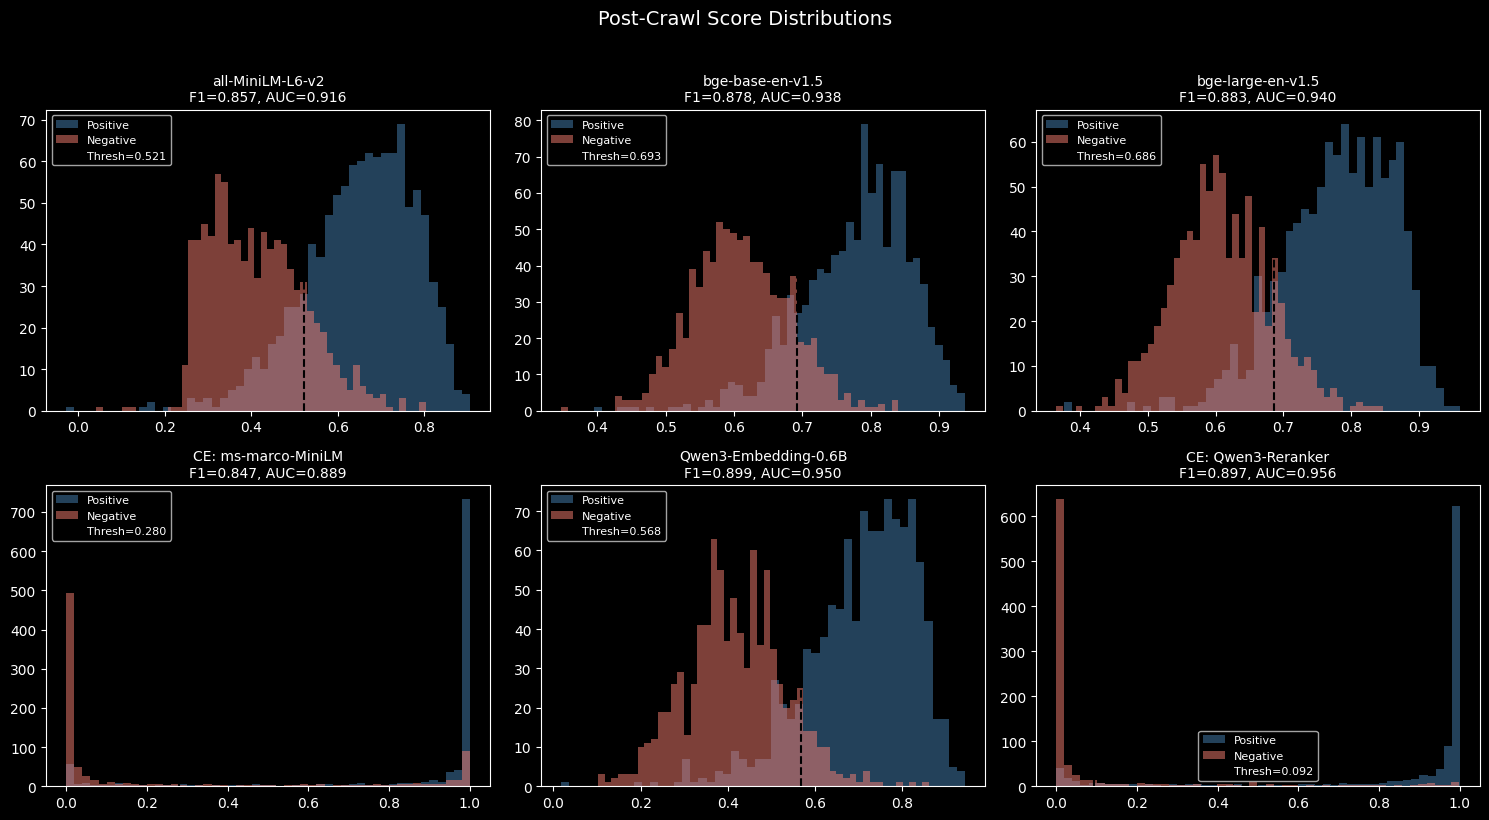

In [18]:
# Cell 13: Score distribution histograms

model_names = list(all_results.keys())
n_models = len(model_names)
cols = 3
rows_grid = (n_models + cols - 1) // cols

fig, axes = plt.subplots(rows_grid, cols, figsize=(5 * cols, 4 * rows_grid))
axes = np.array(axes).flatten()

for i, name in enumerate(model_names):
    ax = axes[i]
    scores = all_results[name]['scores_post']
    m = evaluate_model_scores(scores, df['label'], name)

    pos_scores = scores[df['label'].values]
    neg_scores = scores[~df['label'].values]

    ax.hist(pos_scores, bins=50, alpha=0.5, color='steelblue', label='Positive')
    ax.hist(neg_scores, bins=50, alpha=0.5, color='salmon', label='Negative')
    ax.axvline(m['threshold'], color='black', linestyle='--', label=f'Thresh={m["threshold"]:.3f}')
    ax.set_title(f'{name}\nF1={m["f1"]:.3f}, AUC={m["auc"]:.3f}', fontsize=10)
    ax.legend(fontsize=8)

# Hide unused subplots
for j in range(n_models, len(axes)):
    axes[j].set_visible(False)

fig.suptitle('Post-Crawl Score Distributions', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

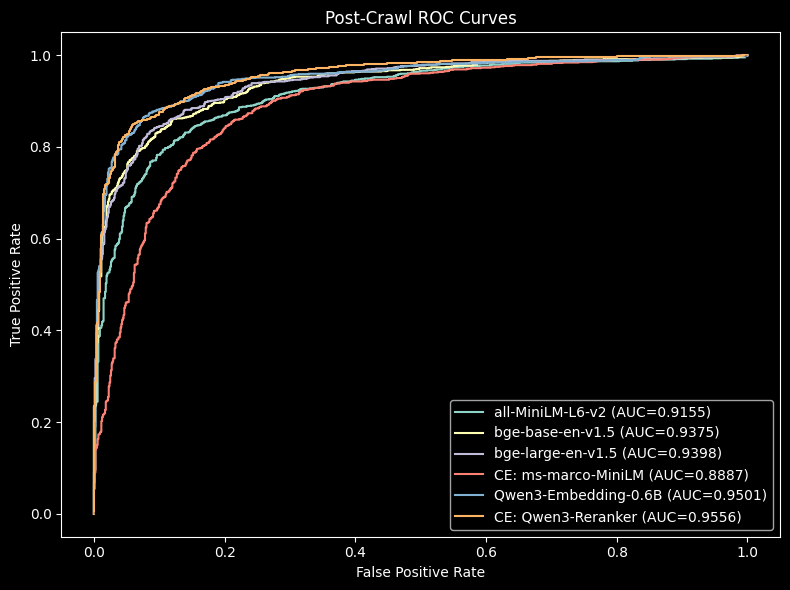

In [19]:
# Cell 14: ROC curves overlay

fig, ax = plt.subplots(figsize=(8, 6))
labels_int = df['label'].astype(int).values

for name, data in all_results.items():
    fpr, tpr, _ = roc_curve(labels_int, data['scores_post'])
    auc_val = roc_auc_score(labels_int, data['scores_post'])
    ax.plot(fpr, tpr, label=f'{name} (AUC={auc_val:.4f})')

ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Post-Crawl ROC Curves')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

,model,accept_thresh,reject_thresh,accept_pct,reject_pct,uncertain_pct,gemini_savings
0,all-MiniLM-L6-v2,0.6363,nan,0.0%,0.0%,100.0%,0.0%
1,bge-base-en-v1.5,0.7299,0.5907,43.1%,19.7%,37.2%,62.8%
2,bge-large-en-v1.5,0.7325,0.6023,42.1%,23.3%,34.5%,65.5%
3,CE: ms-marco-MiniLM,0.9996,0.0000,12.4%,4.2%,83.4%,16.6%
4,Qwen3-Embedding-0.6B,0.5969,0.4155,47.5%,24.2%,28.2%,71.8%
5,CE: Qwen3-Reranker,0.7137,0.0115,47.7%,31.9%,20.5%,79.5%


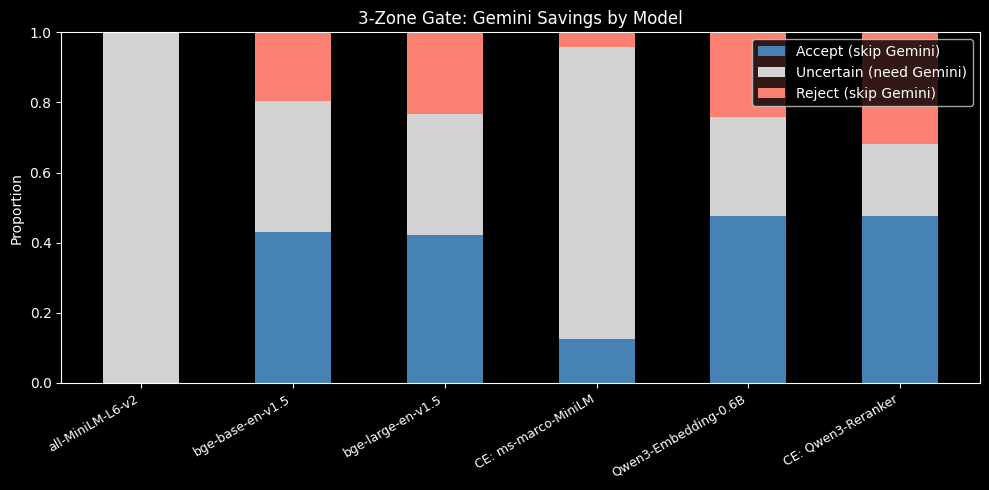

In [20]:
# Cell 15: 3-Zone gate analysis

zone_rows = []
for name, data in all_results.items():
    z = three_zone_analysis(data['scores_post'], df['label'], name)
    zone_rows.append(z)

df_zones = pd.DataFrame(zone_rows)
display(df_zones.style.format({
    'accept_thresh': '{:.4f}', 'reject_thresh': '{:.4f}',
    'accept_pct': '{:.1%}', 'reject_pct': '{:.1%}',
    'uncertain_pct': '{:.1%}', 'gemini_savings': '{:.1%}'
}).set_caption('3-Zone Gate Analysis (95% precision target)'))

# Stacked bar chart
fig, ax = plt.subplots(figsize=(10, 5))
models = df_zones['model']
x = np.arange(len(models))
w = 0.5

ax.bar(x, df_zones['accept_pct'], w, label='Accept (skip Gemini)', color='steelblue')
ax.bar(x, df_zones['uncertain_pct'], w, bottom=df_zones['accept_pct'], label='Uncertain (need Gemini)', color='lightgray')
ax.bar(x, df_zones['reject_pct'], w, bottom=df_zones['accept_pct'] + df_zones['uncertain_pct'], label='Reject (skip Gemini)', color='salmon')

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=30, ha='right', fontsize=9)
ax.set_ylabel('Proportion')
ax.set_title('3-Zone Gate: Gemini Savings by Model')
ax.legend()
plt.tight_layout()
plt.show()

In [21]:
# Cell 16: Cost analysis

DAILY_CRAWLS = 50
GEMINI_COST_PER_CALL = 0.001  # USD estimate

cost_rows = []
for _, row in df_zones.iterrows():
    daily_savings = DAILY_CRAWLS * row['gemini_savings'] * GEMINI_COST_PER_CALL
    cost_rows.append({
        'model': row['model'],
        'gemini_savings_pct': row['gemini_savings'],
        'daily_savings_usd': daily_savings,
        'monthly_savings_usd': daily_savings * 30,
    })

df_cost = pd.DataFrame(cost_rows)
display(df_cost.style.format({
    'gemini_savings_pct': '{:.1%}',
    'daily_savings_usd': '${:.4f}',
    'monthly_savings_usd': '${:.3f}',
}).set_caption('Estimated Cost Savings'))

,model,gemini_savings_pct,daily_savings_usd,monthly_savings_usd
0,all-MiniLM-L6-v2,0.0%,$0.0000,$0.000
1,bge-base-en-v1.5,62.8%,$0.0314,$0.942
2,bge-large-en-v1.5,65.5%,$0.0327,$0.982
3,CE: ms-marco-MiniLM,16.6%,$0.0083,$0.248
4,Qwen3-Embedding-0.6B,71.8%,$0.0359,$1.076
5,CE: Qwen3-Reranker,79.5%,$0.0398,$1.193


=== Pre-Crawl Comparison (wsj_text vs google_title) ===
NOTE: Selection bias — only candidates already chosen by current ranker



/var/folders/_f/cmvp2vmn60j686_xhfbjc4hm0000gn/T/ipykernel_70189/3760072582.py:41: RuntimeWarning: invalid value encountered in divide
  f1 = np.where((precision + recall) > 0, 2 * precision * recall / (precision + recall), 0)


,model,threshold,f1,auc,precision,recall,encode_time_sec
4,Qwen3-Embedding-0.6B,0.5414,0.8705,0.9060,0.8541,0.8876,75.6
5,CE: Qwen3-Reranker,0.7234,0.8671,0.9138,0.8758,0.8586,181.4
1,bge-base-en-v1.5,0.6367,0.8582,0.8996,0.8148,0.9064,7.7
2,bge-large-en-v1.5,0.6655,0.8574,0.9043,0.8767,0.8390,23.8
0,all-MiniLM-L6-v2,0.5327,0.8532,0.8960,0.8415,0.8652,3.1
3,CE: ms-marco-MiniLM,0.2178,0.8023,0.8164,0.7514,0.8605,5.2


/var/folders/_f/cmvp2vmn60j686_xhfbjc4hm0000gn/T/ipykernel_70189/3760072582.py:41: RuntimeWarning: invalid value encountered in divide
  f1 = np.where((precision + recall) > 0, 2 * precision * recall / (precision + recall), 0)


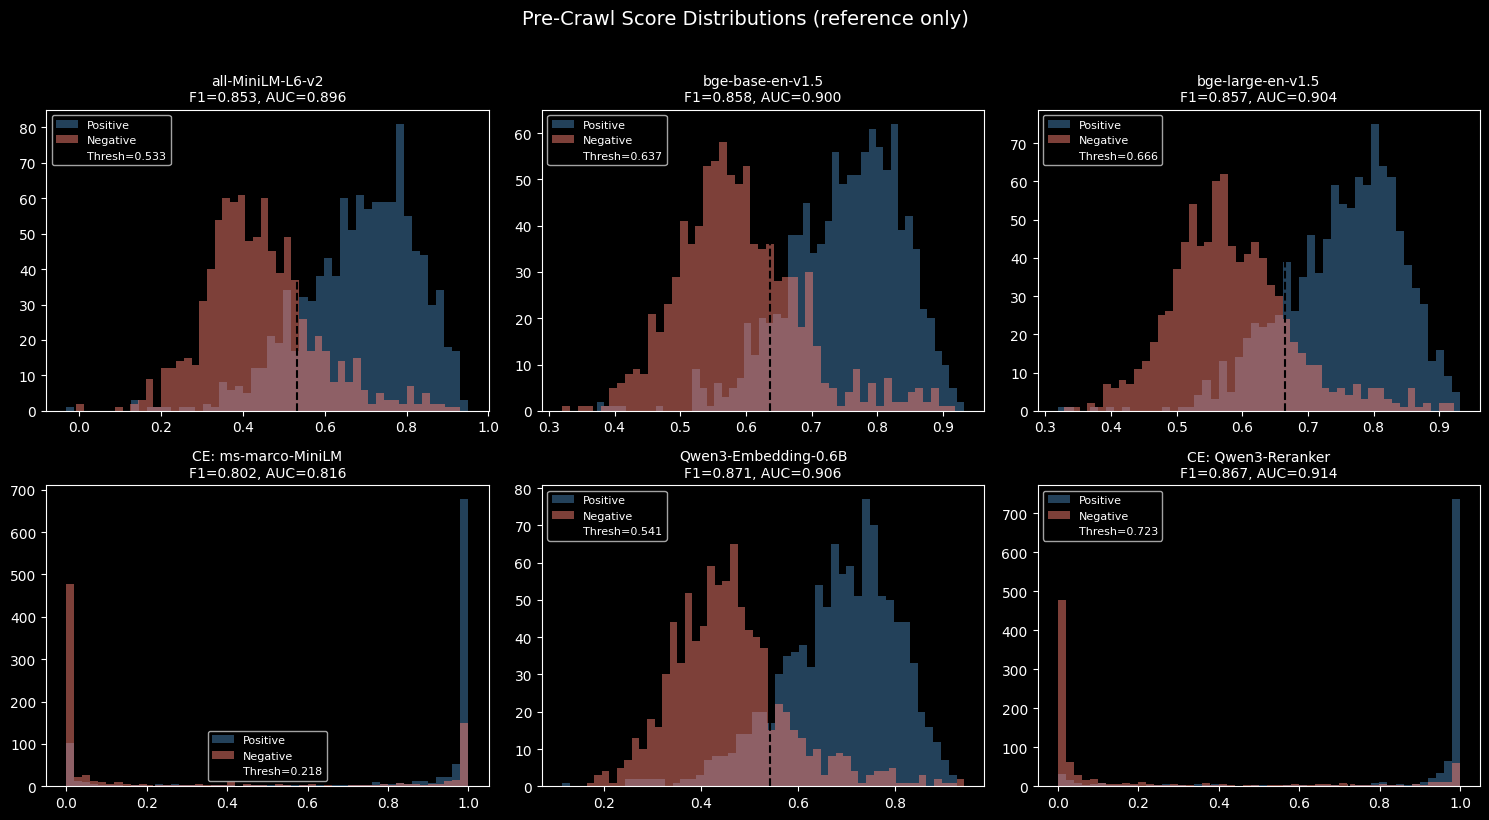

In [22]:
# Cell 17: Pre-crawl comparison (reference only — selection bias applies)

print('=== Pre-Crawl Comparison (wsj_text vs google_title) ===')
print('NOTE: Selection bias — only candidates already chosen by current ranker\n')

pre_rows = []
for name, data in all_results.items():
    if data['scores_pre'] is not None:
        m = evaluate_model_scores(data['scores_pre'], df['label'], name)
        timing = data['timing']
        total_time = timing.get('wsj', 0) + timing.get('pre', 0)
        m['encode_time_sec'] = round(total_time, 1)
        pre_rows.append(m)

df_pre = pd.DataFrame(pre_rows).sort_values('f1', ascending=False)
display(df_pre.style.format({
    'threshold': '{:.4f}', 'f1': '{:.4f}', 'auc': '{:.4f}',
    'precision': '{:.4f}', 'recall': '{:.4f}', 'encode_time_sec': '{:.1f}'
}).set_caption('Pre-Crawl: Model Comparison (reference only)'))

# Score distributions for pre-crawl
n_models = len(pre_rows)
cols = 3
rows_grid = (n_models + cols - 1) // cols
fig, axes = plt.subplots(rows_grid, cols, figsize=(5 * cols, 4 * rows_grid))
axes = np.array(axes).flatten()

for i, name in enumerate([r['model'] for r in pre_rows]):
    ax = axes[i]
    scores = all_results[name]['scores_pre']
    m = evaluate_model_scores(scores, df['label'], name)
    pos_scores = scores[df['label'].values]
    neg_scores = scores[~df['label'].values]
    ax.hist(pos_scores, bins=50, alpha=0.5, color='steelblue', label='Positive')
    ax.hist(neg_scores, bins=50, alpha=0.5, color='salmon', label='Negative')
    ax.axvline(m['threshold'], color='black', linestyle='--', label=f'Thresh={m["threshold"]:.3f}')
    ax.set_title(f'{name}\nF1={m["f1"]:.3f}, AUC={m["auc"]:.3f}', fontsize=10)
    ax.legend(fontsize=8)

for j in range(n_models, len(axes)):
    axes[j].set_visible(False)

fig.suptitle('Pre-Crawl Score Distributions (reference only)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

/var/folders/_f/cmvp2vmn60j686_xhfbjc4hm0000gn/T/ipykernel_62025/1333779849.py:15: RuntimeWarning: invalid value encountered in divide
  f1_2 = np.where((p2 + r2) > 0, 2 * p2 * r2 / (p2 + r2), 0)
/var/folders/_f/cmvp2vmn60j686_xhfbjc4hm0000gn/T/ipykernel_62025/1333779849.py:9: RuntimeWarning: invalid value encountered in divide
  f1 = np.where((p + r) > 0, 2 * p * r / (p + r), 0)


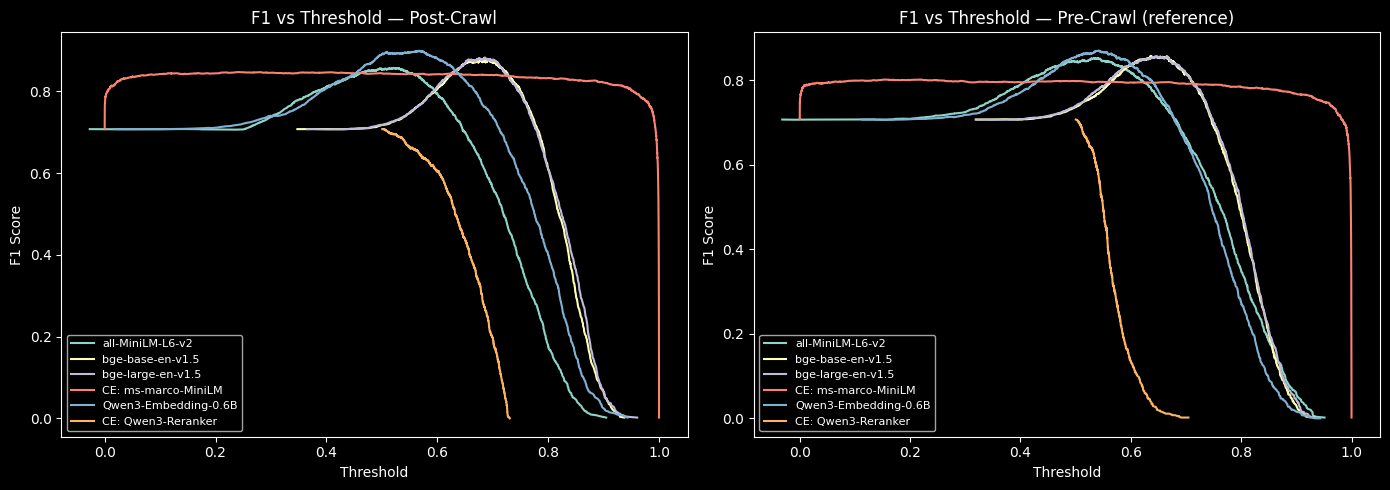

In [29]:
# Cell 18: F1 vs Threshold curves

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
labels_int = df['label'].astype(int).values

for name, data in all_results.items():
    # Post-crawl
    p, r, t = precision_recall_curve(labels_int, data['scores_post'])
    f1 = np.where((p + r) > 0, 2 * p * r / (p + r), 0)
    ax1.plot(t, f1[:-1], label=name)

    # Pre-crawl
    if data['scores_pre'] is not None:
        p2, r2, t2 = precision_recall_curve(labels_int, data['scores_pre'])
        f1_2 = np.where((p2 + r2) > 0, 2 * p2 * r2 / (p2 + r2), 0)
        ax2.plot(t2, f1_2[:-1], label=name)

for ax, title in [(ax1, 'Post-Crawl'), (ax2, 'Pre-Crawl (reference)')]:
    ax.set_xlabel('Threshold')
    ax.set_ylabel('F1 Score')
    ax.set_title(f'F1 vs Threshold — {title}')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# Summary & Next Steps

## Results (fill after running)

| Use Case | Best Model | F1 | AUC | Gemini Savings | Inference Time |
|----------|-----------|-----|-----|----------------|----------------|
| Post-crawl | TBD | - | - | - | - |
| Pre-crawl | TBD | - | - | - | - |

## Data Limitations Recap
1. **Selection bias**: Only candidates already selected by current MiniLM pre-crawl ranker. MiniLM may appear artificially strong.
2. **No Recall@K/MRR**: Cannot measure ranking quality without full candidate pool.
3. **Label coverage**: Only crawl-success rows have LLM labels; failed/skipped crawls excluded.

## Forbidden Conclusions
- "This model improves Recall@K by X%"
- "This will definitely work better on the full candidate distribution"
- "Production savings will exactly match these numbers"

## Next Steps
1. **Full candidate logging**: Store all N=20-50 Google News candidates per WSJ item (not just top_k) for unbiased pre-crawl evaluation
2. **Model swap**: If a model clearly outperforms, update `EMBEDDING_MODEL` in the relevant pipeline script
3. **3-zone gate**: If savings > 30%, implement accept/reject thresholds in `crawl_ranked.py` to skip Gemini calls
4. **Cross-encoder pipeline**: If CE significantly outperforms bi-encoders, consider 2-stage: bi-encoder filter → CE rerank

---
# Qwen3 Standalone Test (MPS)

**Run after kernel restart.** Pickle has bge-base + other model results.
Only load Qwen3-Embedding + Qwen3-Reranker here — fresh MPS memory.

Memory budget:
- Qwen3-Embedding: ~1.2 GB
- Qwen3-Reranker: ~1.2 GB (run sequentially, not together)
- Pickle data: ~2 MB
- Should fit easily in 16 GB

In [30]:
# Step 1: Save current results (run BEFORE kernel restart)
import pickle

save_path = Path('embedding_ab_results.pkl')
with open(save_path, 'wb') as f:
    pickle.dump({
        'all_results': all_results,
        'labels': df['label'].values,
        'wsj_text': df['wsj_text'].tolist(),
        'crawled_text_800': df['crawled_text_800'].tolist(),
        'google_title': df['google_title'].tolist(),
    }, f)
print(f'Saved to {save_path.resolve()} ({save_path.stat().st_size / 1024:.0f} KB)')

Saved to /Users/youngmincho/Project/araverus/notebooks/embedding_ab_results.pkl (2196 KB)


In [16]:
# Step 2: Load saved results + setup (run AFTER kernel restart)
import gc
import os
import pickle
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from scipy.special import expit
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve

save_path = Path('embedding_ab_results.pkl')
with open(save_path, 'rb') as f:
    saved = pickle.load(f)

all_results = saved['all_results']
labels = pd.Series(saved['labels'])
wsj_text = saved['wsj_text']
crawled_text_800 = saved['crawled_text_800']
google_title = saved['google_title']

DEVICE = 'mps' if torch.backends.mps.is_available() else 'cpu'

# Create a minimal df so Cell 12-19 analysis works without re-loading from DB
df = pd.DataFrame({
    'label': labels,
    'wsj_text': wsj_text,
    'crawled_text_800': crawled_text_800,
    'google_title': google_title,
})

# Re-define helper functions needed by analysis cells
def evaluate_model_scores(scores, labels, model_name):
    labels_int = labels.astype(int).values
    auc = roc_auc_score(labels_int, scores)
    precision, recall, thresholds = precision_recall_curve(labels_int, scores)
    f1 = np.where((precision + recall) > 0, 2 * precision * recall / (precision + recall), 0)
    best_idx = np.argmax(f1)
    return {
        'model': model_name,
        'threshold': thresholds[best_idx] if best_idx < len(thresholds) else 0.5,
        'f1': f1[best_idx],
        'auc': auc,
        'precision': precision[best_idx],
        'recall': recall[best_idx],
    }

def three_zone_analysis(scores, labels, model_name, precision_target=0.95):
    labels_int = labels.astype(int).values
    n = len(labels_int)
    sorted_idx = np.argsort(-scores)
    sorted_labels = labels_int[sorted_idx]
    sorted_scores = scores[sorted_idx]
    accept_thresh = None
    cum_tp = np.cumsum(sorted_labels)
    cum_total = np.arange(1, n + 1)
    cum_precision = cum_tp / cum_total
    valid = np.where(cum_precision >= precision_target)[0]
    if len(valid) > 0:
        accept_thresh = sorted_scores[valid[-1]]
    sorted_idx_asc = np.argsort(scores)
    sorted_labels_asc = labels_int[sorted_idx_asc]
    sorted_scores_asc = scores[sorted_idx_asc]
    reject_thresh = None
    cum_tn = np.cumsum(1 - sorted_labels_asc)
    cum_total_asc = np.arange(1, n + 1)
    reject_acc = cum_tn / cum_total_asc
    valid_rej = np.where(reject_acc >= precision_target)[0]
    if len(valid_rej) > 0:
        reject_thresh = sorted_scores_asc[valid_rej[-1]]
    if accept_thresh is not None and reject_thresh is not None and reject_thresh < accept_thresh:
        accept_pct = np.mean(scores >= accept_thresh)
        reject_pct = np.mean(scores <= reject_thresh)
        uncertain_pct = 1 - accept_pct - reject_pct
    else:
        accept_pct = 0
        reject_pct = 0
        uncertain_pct = 1.0
    return {
        'model': model_name,
        'accept_thresh': accept_thresh,
        'reject_thresh': reject_thresh,
        'accept_pct': accept_pct,
        'reject_pct': reject_pct,
        'uncertain_pct': uncertain_pct,
        'gemini_savings': 1 - uncertain_pct,
    }

print(f'Loaded {len(all_results)} model results: {list(all_results.keys())}')
print(f'Samples: {len(df)}, Positive: {df["label"].sum()}')
print(f'Device: {DEVICE}')
print(f'df created with {len(df)} rows — Cell 12-19 ready to run')

Loaded 6 model results: ['all-MiniLM-L6-v2', 'bge-base-en-v1.5', 'bge-large-en-v1.5', 'CE: ms-marco-MiniLM', 'Qwen3-Embedding-0.6B', 'CE: Qwen3-Reranker']
Samples: 1951, Positive: 1068
Device: mps
df created with 1951 rows — Cell 12-19 ready to run


In [2]:
# Step 3: Qwen3-Embedding-0.6B on MPS (fresh kernel)
# NOTE: batch_size=4 to avoid MPS OOM on long texts (800 chars)
from sentence_transformers import SentenceTransformer

def encode_with_timing(model, texts, **kwargs):
    start = time.time()
    embs = model.encode(texts, normalize_embeddings=True, show_progress_bar=True, **kwargs)
    return embs, time.time() - start

def cosine_scores(embs_a, embs_b):
    return np.sum(embs_a * embs_b, axis=1)

model_name = 'Qwen/Qwen3-Embedding-0.6B'
print(f'Loading {model_name} on {DEVICE}...')
model = SentenceTransformer(model_name, trust_remote_code=True, device=DEVICE)

# Encode wsj_text (short) — batch_size=8 is safe
try:
    emb_wsj, t_wsj = encode_with_timing(model, wsj_text, prompt_name='query', batch_size=8)
    print('Using prompt_name="query"')
except Exception:
    print('prompt_name="query" failed, using no prompt')
    emb_wsj, t_wsj = encode_with_timing(model, wsj_text, batch_size=8)

# Post-crawl: crawled_text_800 (long) — batch_size=4 to avoid OOM
emb_post, t_post = encode_with_timing(model, crawled_text_800, batch_size=4)
scores_post = cosine_scores(emb_wsj, emb_post)

# Pre-crawl: google_title (short) — batch_size=8
emb_pre, t_pre = encode_with_timing(model, google_title, batch_size=8)
scores_pre = cosine_scores(emb_wsj, emb_pre)

all_results['Qwen3-Embedding-0.6B'] = {
    'scores_post': scores_post,
    'scores_pre': scores_pre,
    'timing': {'wsj': t_wsj, 'post': t_post, 'pre': t_pre},
}

del model, emb_wsj, emb_post, emb_pre
gc.collect()
torch.mps.empty_cache() if DEVICE == 'mps' else None
print(f'Done. Timing: wsj={t_wsj:.1f}s, post={t_post:.1f}s, pre={t_pre:.1f}s')
print(f'Previous CPU run: total=530s | This MPS run: total={t_wsj+t_post+t_pre:.1f}s')

/Users/youngmincho/Project/araverus/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading Qwen/Qwen3-Embedding-0.6B on mps...


Batches: 100%|██████████| 244/244 [00:50<00:00,  4.85it/s]


Using prompt_name="query"


Batches: 100%|██████████| 244/244 [00:25<00:00,  9.66it/s]


Done. Timing: wsj=50.3s, post=152.5s, pre=25.3s
Previous CPU run: total=530s | This MPS run: total=228.1s


In [3]:
# Step 4: Qwen3-Reranker-0.6B on MPS — correct CausalLM loading
#
# sentence-transformers CrossEncoder loaded this as SequenceClassification → broken (AUC 0.49)
# Correct: CausalLM that predicts "yes"/"no" token probabilities

from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

model_name = 'Qwen/Qwen3-Reranker-0.6B'
print(f'Loading {model_name} on {DEVICE} (CausalLM)...')

tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
reranker = AutoModelForCausalLM.from_pretrained(
    model_name, torch_dtype=torch.float32,
).to(DEVICE).eval()

token_true_id = tokenizer.convert_tokens_to_ids("yes")
token_false_id = tokenizer.convert_tokens_to_ids("no")

PREFIX = '<|im_start|>system\nJudge whether the Document meets the requirements based on the Query and the Instruct provided. Note that the answer can only be "yes" or "no".<|im_end|>\n<|im_start|>user\n'
SUFFIX = '<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n'
INSTRUCTION = 'Given a news headline and description, determine if the document covers the same event'

prefix_tokens = tokenizer.encode(PREFIX, add_special_tokens=False)
suffix_tokens = tokenizer.encode(SUFFIX, add_special_tokens=False)
max_length = 2048


def format_pair(query, doc):
    return f'<Instruct>: {INSTRUCTION}\n<Query>: {query}\n<Document>: {doc}'


@torch.no_grad()
def rerank_batch(queries, docs, batch_size=2):
    pairs = [format_pair(q, d) for q, d in zip(queries, docs)]
    all_scores = []

    for i in tqdm(range(0, len(pairs), batch_size), desc='Reranking'):
        batch = pairs[i:i + batch_size]
        inputs = tokenizer(
            batch, padding=False, truncation=True,
            return_attention_mask=False,
            max_length=max_length - len(prefix_tokens) - len(suffix_tokens)
        )
        for j in range(len(inputs['input_ids'])):
            inputs['input_ids'][j] = prefix_tokens + inputs['input_ids'][j] + suffix_tokens

        inputs = tokenizer.pad(inputs, padding=True, return_tensors='pt', max_length=max_length)
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

        logits = reranker(**inputs).logits[:, -1, :]
        true_logits = logits[:, token_true_id]
        false_logits = logits[:, token_false_id]
        probs = torch.nn.functional.softmax(
            torch.stack([false_logits, true_logits], dim=1), dim=1
        )
        scores = probs[:, 1].cpu().numpy()
        all_scores.extend(scores.tolist())

    return np.array(all_scores)


# Post-crawl (batch_size=2 for long texts)
start = time.time()
scores_post = rerank_batch(wsj_text, crawled_text_800, batch_size=2)
t_post = time.time() - start

# Pre-crawl (batch_size=4 for short texts)
start = time.time()
scores_pre = rerank_batch(wsj_text, google_title, batch_size=4)
t_pre = time.time() - start

all_results['CE: Qwen3-Reranker'] = {
    'scores_post': scores_post,
    'scores_pre': scores_pre,
    'timing': {'post': t_post, 'pre': t_pre},
}

del reranker, tokenizer
gc.collect()
torch.mps.empty_cache() if DEVICE == 'mps' else None
print(f'Done. Timing: post={t_post:.1f}s, pre={t_pre:.1f}s')
print(f'Score range — post: [{scores_post.min():.4f}, {scores_post.max():.4f}], pre: [{scores_pre.min():.4f}, {scores_pre.max():.4f}]')

Loading Qwen/Qwen3-Reranker-0.6B on mps (CausalLM)...


`torch_dtype` is deprecated! Use `dtype` instead!
Reranking:   0%|          | 0/976 [00:00<?, ?it/s]You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/Users/youngmincho/Project/araverus/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2919: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
Reranking: 100%|██████████| 488/488 [03:01<00:00,  2.69it/s]


Done. Timing: post=442.3s, pre=181.4s
Score range — post: [0.0000, 0.9998], pre: [0.0000, 0.9997]


In [4]:
# Step 5: Save updated results
with open(save_path, 'wb') as f:
    pickle.dump({
        'all_results': all_results,
        'labels': labels.values,
        'wsj_text': wsj_text,
        'crawled_text_800': crawled_text_800,
        'google_title': google_title,
    }, f)

print(f'Final models ({len(all_results)}): {list(all_results.keys())}')
print('\n=> Re-run Cell 12-19 to update analysis with new results.')

Final models (6): ['all-MiniLM-L6-v2', 'bge-base-en-v1.5', 'bge-large-en-v1.5', 'CE: ms-marco-MiniLM', 'Qwen3-Embedding-0.6B', 'CE: Qwen3-Reranker']

=> Re-run Cell 12-19 to update analysis with new results.
